### Control Parameters 

In [1]:
%load_ext lab_black
%load_ext pycodestyle_magic

In [2]:
%flake8_on -i E203,E501 -m 119

In [3]:
import datetime
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load

In [4]:
# parameters
exp_index = [
    "coil",
    "double_coil",
    #     "reverse_coil",
    #     "reverse_double_coil",
    #     "down_coil",
    #     "reverse_down_coil",
    #     "square",
    #     "double_square",
    #     "lines",
    #     "lines2",
    #     "reverse_lines",
    #     "reverse_lines2",
    #     "manual",
    #             'manual_wind',
    #             'coil_reverse_double_wind',
    #             'coil_double_wind',
    #             'squre_double_wind'
]

policy_xy_not_z = False
data_folder_path = "./blimpSim/data/behaviour_policy"
if policy_xy_not_z:
    SimResults_path = "./blimpSim/results_XY"
    RealResults_path = "./blimpReal/results_XY"
    mix_results_path = "./blimpSim/mix_results_XY"
else:
    SimResults_path = "./blimpSim/results_Z"
    RealResults_path = "./blimpReal/results_Z"
    mix_results_path = "./blimpSim/mix_results_Z"

name_space = "blimp-"


class Msg_structure:
    def __init__(self, name=None, feature_list=None, feature_rename_list=None):
        self.name = name
        self.feature_list = feature_list
        self.feature_rename_list = feature_rename_list


Imu_msg = Msg_structure(
    name="tail-imu",
    feature_list=[
        "Time",
        "linear_acceleration.x",
        "linear_acceleration.y",
        "linear_acceleration.z",
    ],
    feature_rename_list=[
        "Time",
        "linear_acceleration.x",
        "linear_acceleration.y",
        "linear_acceleration.z",
    ],
)
orientation_msg = Msg_structure(
    name=name_space + "pose",
    feature_list=[
        "Time",
        "orientation.x",
        "orientation.y",
        "orientation.z",
        "orientation.w",
        "angVelocity.x",
        "angVelocity.y",
        "angVelocity.z",
        "velocity.x",
        "velocity.y",
        "velocity.z",
    ],
    feature_rename_list=[
        "Time",
        "orientation.x",
        "orientation.y",
        "orientation.z",
        "orientation.w",
        "angVelocity.x",
        "angVelocity.y",
        "angVelocity.z",
        "velocity.linear.x",
        "velocity.linear.y",
        "velocity.linear.z",
    ],
)
autopilotInfo_msg = Msg_structure(
    name=name_space + "AutopilotInfo",
    feature_list=[
        "Time",
        "VelocityDesired.x",
        "VelocityDesired.y",
        "VelocityDesired.z",
    ],
    feature_rename_list=[
        "Time",
        "target.velocity.x",
        "target.velocity.y",
        "target.velocity.z",
    ],
)

obs_msg = [Imu_msg, orientation_msg, autopilotInfo_msg]

actuator_command_msg = Msg_structure(
    name="actuatorcommand",
    feature_list=["Time", "data.data"],
    feature_rename_list=[
        "Time",
        "m2",
        "lfin",
        "rfin",
        "tfin",
        "bfin",
        "stick",
        "m1",
        "unused0",
        "m0",
        "unused1",
        "unused2",
        "unused3",
    ],
)
actuator_msg = Msg_structure(
    name=name_space + "actuators",
    feature_list=["Time", "data.data"],
    feature_rename_list=[
        "Time",
        "m2",
        "lfin",
        "rfin",
        "tfin",
        "bfin",
        "stick",
        "m1",
        "unused0",
        "m0",
        "unused1",
        "unused2",
        "unused3",
    ],
)
# act_msg = [actuator_msg, actuator_command_msg] #TODO: add act command as training data as well
act_msg = [actuator_msg]
all_msg = obs_msg + act_msg

In [5]:
# Load csv files
bool_convert_rosbag2csv = True

pseudo_target_distribution_const = 0.2
pseudo_target_min = np.array([-10, -10, -3])
pseudo_target_max = np.array([10, 10, 3])
pseudo_target_name_list = autopilotInfo_msg.feature_rename_list
pseudo_target_features_num = len(pseudo_target_name_list) - 1

num_transitions = 2
assert num_transitions >= 2, "num_transitions should be greater than 2"

obs_feature_msg = [msg.feature_rename_list for msg in obs_msg]
act_feature_msg = [msg.feature_rename_list for msg in act_msg]
obs_feature_list = list(set([item for sublist in obs_feature_msg for item in sublist]))
act_feature_list = list(set([item for sublist in act_feature_msg for item in sublist]))

time_feature_name = "Time"
purge_feature_list = [
    "ROSControlled",
    "Armed",
    "Thrust",
    "unused0",
    "unused1",
    "unused2",
    "unused3",
]
purge_feature_list.append(time_feature_name)

merge_feature = [time_feature_name]
merge_feature = merge_feature.append(act_feature_list)

# Data processing
round_time = 1

obs_filter_feature = [
    item
    for sublist in obs_feature_msg
    for item in sublist
    if item is not time_feature_name
]
act_filter_feature = ["m2", "lfin", "rfin", "tfin", "bfin", "stick", "m1", "m0"]
train_test_split_ratio = (0.99, 0.01)
act_scale_bnd = {
    "act_max": 2000,
    "act_min": 1000,
    "scaled_act_max": 1,
    "scaled_act_min": -1,
}

bool_addTarget = True
num_target_df = 7
generate_target_distribution_const = 1
target_feature_list = ["target.velocity.x", "target.velocity.y", "target.velocity.z"]

bool_addNoise = True
num_noise_df = 7
noise_level = 0.05

bool_round = False
rounding_factor = 3

# Define Reward Function
target_feature_list = target_feature_list
obsCost_feature_list = ["velocity.linear.x", "velocity.linear.y", "velocity.linear.z"]
xy_target_feature_list = target_feature_list[0:1]
xy_cost_feature_list = obsCost_feature_list[0:1]
z_target_feature_list = target_feature_list[2]
z_cost_feature_list = obsCost_feature_list[2]
actCost_feature_list = ["m0", "m1", "m2"]
actChangeCost_feature_list = ["m0", "m1", "m2", "stick", "tfin", "bfin", "lfin", "rfin"]

weight_next_obs = 1
weight_prev_obs = 0 * 1 / (num_transitions - 1)
weight_prev_act = 0 * 1 / (num_transitions - 1)
weight_prev_actChange = 0 * 1 / (num_transitions - 1)
reward_weights = (
    weight_next_obs,
    weight_prev_obs,
    weight_prev_act,
    weight_prev_actChange,
)

if policy_xy_not_z:
    weight_xy_obs, weigth_z_obs = 1, 0
else:
    weight_xy_obs, weigth_z_obs = 0, 1
obs_reward_weights = (weight_xy_obs, weigth_z_obs)

# Create parameter dics
params = {
    "exp_index": exp_index,
    "data_folder_path": data_folder_path,
    "RealResults_path": RealResults_path,
    "SimResults_path": SimResults_path,
    "mix_results_path": mix_results_path,
    "bool_convert_rosbag2csv": bool_convert_rosbag2csv,
    "all_msg": all_msg,
    "obs_msg": obs_msg,
    "act_msg": act_msg,
    "pseudo_target_name_list": pseudo_target_name_list,
    "pseudo_target_distribution_const": pseudo_target_distribution_const,
    "pseudo_target_features_num": pseudo_target_features_num,
    "pseudo_target_min": pseudo_target_min,
    "pseudo_target_max": pseudo_target_max,
    "num_transitions": num_transitions,
    "target_feature_list": target_feature_list,
    "xy_target_feature_list": xy_target_feature_list,
    "z_target_feature_list": z_target_feature_list,
    "obs_feature_list": obs_feature_list,
    "act_feature_list": act_feature_list,
    "time_feature_name": time_feature_name,
    "purge_feature_list": purge_feature_list,
    "round_time": round_time,
    "act_filter_feature": act_filter_feature,
    "obs_filter_feature": obs_filter_feature,
    "train_test_split_ratio": train_test_split_ratio,
    "act_scale_bnd": act_scale_bnd,
    "bool_addTarget": bool_addTarget,
    "num_target_df": num_target_df,
    "generate_target_distribution_const": generate_target_distribution_const,
    "bool_addNoise": bool_addNoise,
    "num_noise_df": num_noise_df,
    "noise_level": noise_level,
    "bool_round": bool_round,
    "rounding_factor": rounding_factor,
    "obsCost_feature_list": obsCost_feature_list,
    "xy_cost_feature_list": xy_cost_feature_list,
    "z_cost_feature_list": z_cost_feature_list,
    "actCost_feature_list": actCost_feature_list,
    "actChangeCost_feature_list": actChangeCost_feature_list,
    "reward_weights": reward_weights,
    "obs_reward_weights": obs_reward_weights,
}

### Convert rosbag to csv

In [6]:
if params["bool_convert_rosbag2csv"]:
    import bagpy
    from bagpy import bagreader
    from pathlib import Path

    class ConvertBag2csv:
        def __init__(self):
            pass

        def rosbag2csv(self, rosbag_path):
            b = bagreader(rosbag_path)
            csvfiles = []
            for t in b.topics:
                data = b.message_by_topic(t)
                csvfiles.append(data)

        def convert_rosbag2csv(self, directory):
            for root, dirs, files in os.walk(directory):
                for file in files:
                    if file.endswith(".bag"):
                        try:
                            bag_path = os.path.join(root, file)
                            file_path = os.path.splitext(bag_path)[0]
                            if not os.path.exists(file_path):
                                print(f"bag: start convert {file} ...")
                                self.rosbag2csv(bag_path)
                            else:
                                print(f"bag: {file} already converted")
                        except RuntimeError:
                            print(
                                f"bag: not able to convert {file}, maybe it is broken"
                            )

    print(f"data_folder_path: {data_folder_path}")
    clsConvertBag2csv = ConvertBag2csv()

    print("----------Start Converting Rosbag to CSV files----------")
    clsConvertBag2csv.convert_rosbag2csv(data_folder_path)
    print("----------Finish Convert----------")

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


data_folder_path: ./blimpSim/data/behaviour_policy
----------Start Converting Rosbag to CSV files----------
bag: square.bag already converted
bag: lines.bag already converted
bag: reverse_lines.bag already converted
bag: reverse_coil.bag already converted
bag: reverse_down_coil.bag already converted
bag: double_square.bag already converted
bag: coil.bag already converted
bag: lines2.bag already converted
bag: manual.bag already converted
bag: reverse_lines2.bag already converted
bag: double_coil.bag already converted
bag: reverse_double_coil.bag already converted
bag: down_coil.bag already converted
----------Finish Convert----------


### Load data from csv files

In [7]:
class objTransitions:
    def __init__(
        self,
        df=None,
        num_transitions=2,
        act_filter_feature=[],
        obs_filter_feature=[],
        purge_feature_list=["Time"],
        time_feature_name=["Time"],
        **kwargs
    ):
        self.df = df
        self.num_transitions = num_transitions
        assert self.num_transitions >= 2

        self.act_filter_feature = act_filter_feature
        self.obs_filter_feature = obs_filter_feature
        self.purge_feature_list = purge_feature_list
        self.time_feature_name = time_feature_name

        self.time = None
        self.act_trans_list = []
        self.obs_trans_list = []

        if df is not None:
            self._update()

    def _update(self):
        self.df_len = len(self.df.index)
        self.trans_len = len(self.df.index) - self.num_transitions
        self.time = self.get_time()
        self.act_trans_list, self.obs_trans_list = self._split_df(self.df)
        self._reset_index()

    def _calculate_delta_obs(self, obs, next_obs):
        return next_obs - obs

    def _split_df(self, df):
        act_trans_list, obs_trans_list = [], []
        for i in range(self.num_transitions):
            act_obs_trans = df[i : self.df_len - self.num_transitions + 1 + i]
            act_obs_trans.reset_index(drop=True)
            act_trans, obs_trans = (
                act_obs_trans[self.act_filter_feature],
                act_obs_trans[self.obs_filter_feature],
            )
            act_trans, obs_trans = self._purge_feature(act_trans), self._purge_feature(
                obs_trans
            )
            act_trans_list.append(act_trans)
            obs_trans_list.append(obs_trans)
        return act_trans_list, obs_trans_list

    def _purge_feature(self, df):
        for feature in self.purge_feature_list:
            if feature in df.columns:
                print("[ objTransition ] purge feature from df: ", feauture)
                df = df.drop(feature, axis=1)
        return df

    def _reset_index(self):
        self.df.reset_index(drop=True, inplace=True)
        for i in range(self.num_transitions):
            self.act_trans_list[i].reset_index(drop=True, inplace=True)
            self.obs_trans_list[i].reset_index(drop=True, inplace=True)

    def get_next_transitions(self):
        next_act, next_obs = (
            self.act_trans_list[self.num_transitions - 1],
            self.obs_trans_list[self.num_transitions - 1],
        )
        return next_act, next_obs

    def get_cur_transitions(self):
        act, obs = (
            self.act_trans_list[self.num_transitions - 2],
            self.obs_trans_list[self.num_transitions - 2],
        )
        return act, obs

    def get_prev_transitions_list(self):
        prev_act_df_list, prev_obs_df_list = (
            self.act_trans_list[: self.num_transitions - 1],
            self.obs_trans_list[: self.num_transitions - 1],
        )
        return prev_act_df_list, prev_obs_df_list

    def get_delta_obs_transitions(self):
        _, next_obs = self.get_next_transitions()
        _, cur_obs = self.get_cur_transitions()
        delta_obs = self._calculate_delta_obs(cur_obs, next_obs)
        return delta_obs

    def get_time(self):
        return self.df[self.time_feature_name]

In [8]:
class Load_data:
    def __init__(self):
        pass

    def load_csv_index(self, directory):
        csv_index = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    path = os.path.join(root, file)
                    csv_index.append(path)
        return csv_index

    # *******************************************

    def create_df_from_csvIndex(self, csv_index, **params):
        df_list = self.read_csvfiles(csv_index, **params)
        df = self.merge_df_list(df_list, merge_feature)
        df = df.sort_values(by="Time", ignore_index=True)
        return df

    def read_csvfiles(self, csv_index, **params):
        df_list = []
        for msg in all_msg:
            print("[ Load Data ] read_csvfiles: ", msg.name)
            if (msg.name == "AutopilotInfo") and self.csv_not_exist(
                csv_index, msg.name
            ):
                print(
                    "[ Load Data ] read_csvfiles, AutopilotInfo doesn't exist, generating..."
                )
                time_df = df["Time"]
                df = self.generate_fake_AutopilotInfo(time_df, **params)
                df_list.append(df)

            elif (msg.name == "actuatorcommand") and self.csv_not_exist(
                csv_index, msg.name
            ):
                print(
                    "[ Load Data ] read_csvfiles, actuatorcommand.csv does not exist, skip..."
                )

            else:
                df = self.create_df(
                    csv_index,
                    msg.name,
                    msg.feature_list,
                    msg.feature_rename_list,
                    **params
                )
                df_list.append(df)
        return df_list

    def create_df(
        self, csv_index, msg_name, feature_list, feature_rename_list, **params
    ):
        df = self.read_df_from_msg_in_csvIndex(csv_index, msg_name, **params)
        df = df[feature_list]
        df = self.unwrap_features(df)
        df.columns = feature_rename_list
        return df

    def read_df_from_msg_in_csvIndex(self, csv_index, msg_name, **params):
        for csv_name in csv_index:
            if msg_name in csv_name:
                print(csv_name)
                df = pd.read_csv(csv_name)
        return df

    def merge_df_list(self, df_list, merge_feature):
        df = df_list[0]
        iter_data = iter(df_list)
        next(iter_data)
        for item in iter_data:
            df = pd.merge(df, item, how="outer", on=merge_feature)
        return df

    # *******************************************

    def unwrap_features(self, df):
        for col_name in df.columns:
            col = df[col_name]
            col_data_type = self.check_col_data_type(col)

            if col_data_type == tuple:
                df = self.unwrap_tuple_feature(df, col_name)

        return df

    def check_col_data_type(self, col):
        first_element = col[0]
        data_type = type(first_element)

        if data_type == str:
            col = col.map(lambda x: eval(x))
            first_element = col[0]
            data_type = type(first_element)

        return data_type

    def unwrap_tuple_feature(self, df, col_name):
        tuple_col = df.pop(col_name)
        tuple_col = tuple_col.map(lambda x: eval(x))

        first_element = tuple_col[0]
        feature_len = len(first_element)

        feature_list = []
        for i in range(feature_len):
            new_feature = tuple_col.str[i]
            feature_list.append(new_feature)

        feature_pd = pd.concat(feature_list, axis=1)
        df = pd.concat([df, feature_pd], axis=1)

        return df

    # *******************************************

    def csv_not_exist(self, csv_index, msg_name):
        target_csv = [csv_name for csv_name in csv_index if msg_name in csv_name]
        if len(target_csv) == 0:
            return True
        else:
            return False

    def generate_fake_AutopilotInfo(self, time_df, **params):
        time_len = len(time_df.index)
        pseudo_target_shape = (time_len, pseudo_target_features_num)
        pseudo_target_df = self.generate_pseudo_target(pseudo_target_shape, **params)
        df = pd.concat([time_df, pseudo_target_df], axis=1)
        df.columns = pseudo_target_name_list
        return df

    def generate_pseudo_target(self, pseudo_target_shape, **params):
        target_noise = pseudo_target_distribution_const * np.random.normal(
            pseudo_target_min, pseudo_target_max, pseudo_target_shape
        )
        pseudo_target_df = pd.DataFrame(target_noise)
        return pseudo_target_df

    # *******************************************

    def clean_df(self, df, act_filter_feature, act_scale_bnd, round_time, **params):
        df = self.fill_df_NA(df)
        df = self.clean_act_bnd_error(df, act_scale_bnd, act_filter_feature)
        df = self.clean_time_sequence(df, round_time)
        return df

    def fill_df_NA(self, df):
        df = df.fillna(method="ffill")
        df = df.fillna(0)
        return df

    def clean_act_bnd_error(self, df, act_scale_bnd, act_filter_feature):
        df = self.clip_df(
            df, act_scale_bnd["act_min"], act_scale_bnd["act_max"], act_filter_feature
        )
        return df

    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[df[filter_feature] >= df_min]
            df = df[df[filter_feature] <= df_max]
        df.reset_index(drop=True, inplace=True)
        return df

    def clean_time_sequence(self, df, round_time=1):
        time = df["Time"]
        time = time.round(round_time)
        time = time.drop_duplicates()
        df = df.loc[time.index]
        return df

    # *******************************************

    def concat_df(self, df, df_new):
        if df is None:
            return df_new
        else:
            df = pd.concat([df, df_new], axis=0, ignore_index=True)
        return df

    # *******************************************

    def main(self, **params):
        df = None

        for exp in exp_index:
            exp_path = os.path.join(data_folder_path, exp)

            print("[ LOAD csv ]", exp)
            csv_index = self.load_csv_index(exp_path)

            print("[ CREATE df ] start", csv_index)
            new_df = self.create_df_from_csvIndex(csv_index, **params)

            print("[ Clean df ] start")
            new_df = self.clean_df(new_df, **params)

            print("[ CONCAT df ] start")
            df = self.concat_df(df, new_df)

        print("[ Create Transitions ] Start")
        objTrans = objTransitions(df, **params)

        print("[ LOAD csv ] Complete")
        return objTrans

In [9]:
clsLoadData = Load_data()
objTrans = clsLoadData.main(**params)

[ LOAD csv ] coil
[ CREATE df ] start ['./blimpSim/data/behaviour_policy/coil/blimp-tail-position.csv', './blimpSim/data/behaviour_policy/coil/blimp-TransmitterInfo.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-imu.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-actuators.csv', './blimpSim/data/behaviour_policy/coil/blimp-GCSACTUATORS.csv', './blimpSim/data/behaviour_policy/coil/blimp-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-AutopilotInfo.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_speed.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-imu.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-transform.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-position.csv']
[ Load Data ] read_csvfiles:  tail-imu
./blimpSim/data/behaviour_policy/coil/blimp-tail-imu.csv
[ Load Data ] read_csvfile

In [10]:
objTrans.df

,Time,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,...,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,40.720,0.584692,-0.003121,9.895689,-0.000153,0.023304,0.001966,0.999726,-0.023512,1.377563,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
1,40.750,0.594369,-0.002353,9.892905,-0.000150,0.023693,0.001969,0.999717,-0.013437,1.268200,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
2,40.855,0.614525,0.000782,9.879537,-0.000144,0.024206,0.001974,0.999705,-0.012377,1.201045,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
3,40.950,0.625241,-0.001828,9.871389,-0.000136,0.025340,0.001989,0.999677,-0.018434,0.884534,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
4,41.055,0.617526,-0.000545,9.875700,-0.000131,0.025696,0.001995,0.999668,-0.014570,0.687310,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,530.350,0.391502,-0.010318,9.790221,0.006076,0.019827,-0.279586,0.959897,-0.094367,0.034331,...,1549.0,1507.0,1507.0,1135.0,1615.0,1000.0,1615.0,1000.0,1000.0,1000.0
4513,530.455,0.392566,-0.010046,9.791321,0.005978,0.019899,-0.279610,0.959889,-0.060054,0.037899,...,1550.0,1507.0,1507.0,1137.0,1614.0,1000.0,1614.0,1000.0,1000.0,1000.0
4514,530.550,0.391860,-0.012115,9.789707,0.005925,0.019953,-0.279641,0.959879,-0.052665,0.037298,...,1550.0,1508.0,1508.0,1134.0,1614.0,1000.0,1614.0,1000.0,1000.0,1000.0
4515,530.655,0.393841,-0.011527,9.790220,0.005876,0.020000,-0.279677,0.959868,-0.056537,0.036828,...,1550.0,1508.0,1508.0,1134.0,1614.0,1000.0,1614.0,1000.0,1000.0,1000.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8990d48f40>,
      dtype=object)

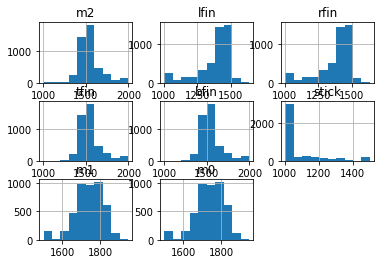

In [11]:
cur_act, cur_obs = objTrans.get_cur_transitions()
cur_act.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89910a4730>,
      dtype=object)

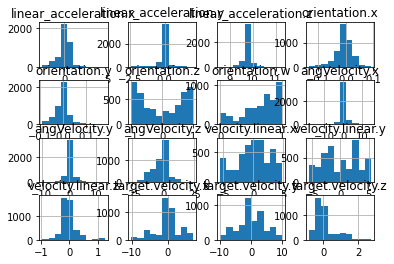

In [12]:
cur_obs.hist()

In [13]:
objTrans.get_time()

0        40.720
1        40.750
2        40.855
3        40.950
4        41.055
         ...   
4512    530.350
4513    530.455
4514    530.550
4515    530.655
4516    530.750
Name: Time, Length: 4517, dtype: float64

In [21]:
displa(objTrans.df)

,Time,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,...,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,40.720,0.584692,-0.003121,9.895689,-0.000153,0.023304,0.001966,0.999726,-0.023512,1.377563,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0
1,40.750,0.594369,-0.002353,9.892905,-0.000150,0.023693,0.001969,0.999717,-0.013437,1.268200,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0
2,40.855,0.614525,0.000782,9.879537,-0.000144,0.024206,0.001974,0.999705,-0.012377,1.201045,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0
3,40.950,0.625241,-0.001828,9.871389,-0.000136,0.025340,0.001989,0.999677,-0.018434,0.884534,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0
4,41.055,0.617526,-0.000545,9.875700,-0.000131,0.025696,0.001995,0.999668,-0.014570,0.687310,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,530.350,0.391502,-0.010318,9.790221,0.006076,0.019827,-0.279586,0.959897,-0.094367,0.034331,...,0.098,0.014,0.014,-0.730,0.230,1000.0,0.230,1000.0,1000.0,1000.0
4513,530.455,0.392566,-0.010046,9.791321,0.005978,0.019899,-0.279610,0.959889,-0.060054,0.037899,...,0.100,0.014,0.014,-0.726,0.228,1000.0,0.228,1000.0,1000.0,1000.0
4514,530.550,0.391860,-0.012115,9.789707,0.005925,0.019953,-0.279641,0.959879,-0.052665,0.037298,...,0.100,0.016,0.016,-0.732,0.228,1000.0,0.228,1000.0,1000.0,1000.0
4515,530.655,0.393841,-0.011527,9.790220,0.005876,0.020000,-0.279677,0.959868,-0.056537,0.036828,...,0.100,0.016,0.016,-0.732,0.228,1000.0,0.228,1000.0,1000.0,1000.0


### Data processing

In [14]:
class Data_processing:
    def __init__(self):
        pass

    def data_processsing(self, df, **params):
        df = self.scale_df_act(df, act_scale_bnd, act_filter_feature)
        if bool_addTarget:
            df = self.duplicate_target_df(df, **params)
        if bool_addNoise:
            df = self.duplicate_Noise_df(df, num_noise_df, noise_level)
        if bool_round:
            df = self.round_df(df, rounding_factor)
        df = self.clip_scaled_df(df, act_scale_bnd, act_filter_feature)
        return df

    def scale_df_act(self, df, act_scale_bnd, act_filter_feature):
        act_max, act_min = act_scale_bnd["act_max"], act_scale_bnd["act_min"]
        scaled_act_max, scaled_act_min = (
            act_scale_bnd["scaled_act_max"],
            act_scale_bnd["scaled_act_min"],
        )

        act = df[act_filter_feature]
        act = self.minmax_scale_df(
            act, act_max, act_min, scaled_act_max, scaled_act_min
        )
        df[act_filter_feature] = act
        return df

    def minmax_scale_df(self, df, df_max, df_min, target_max, target_min):
        df_mean = (df_max + df_min) / 2
        target_mean = (target_max + target_min) / 2

        scale = (df_max - df_min) / (target_max - target_min)
        df = (df - df_mean) / scale + target_mean
        return df

    def duplicate_target_df(self, df, num_target_df, **params):
        new_df = df
        df_len = len(df.index)
        pseudo_target_shape = (df_len, len(target_feature_list))

        for i in range(num_target_df):
            pseudo_target_df = self.generate_pseudo_target(
                pseudo_target_shape, **params
            )
            pseudo_target_df.columns = target_feature_list
            df[target_feature_list] = pseudo_target_df
            new_df = pd.concat([new_df, df], axis=0, ignore_index=True)
        return new_df

    def generate_pseudo_target(self, pseudo_target_shape, **params):
        target_noise = generate_target_distribution_const * np.random.uniform(
            pseudo_target_min, pseudo_target_max, pseudo_target_shape
        )
        pseudo_target_df = pd.DataFrame(target_noise)
        return pseudo_target_df

    def duplicate_Noise_df(self, df, num_noise_df, noise_level):
        new_df = df
        time_df = df["Time"]
        df = df.drop("Time", axis=1)
        for i in range(num_noise_df):
            noised_df = self.addNoise_df(df, noise_level)
            noised_df = pd.concat([time_df, noised_df], axis=1)
            new_df = pd.concat([new_df, noised_df], axis=0, ignore_index=True)

        return new_df

    def addNoise_df(self, df, noise_level):
        df_range = df.max() - df.min()
        df_noise_range = noise_level * df_range / 2
        noise = np.random.uniform(-df_noise_range, df_noise_range, df.shape)
        df = df + noise
        return df

    def round_df(self, df, rounding_factor):
        new_df = df.round(rounding_factor)
        return new_df

    def clip_scaled_df(self, df, act_scale_bnd, act_filter_feature):
        scaled_act_min, scaled_act_max = (
            act_scale_bnd["scaled_act_min"],
            act_scale_bnd["scaled_act_max"],
        )
        new_df = self.clip_df(df, scaled_act_min, scaled_act_max, act_filter_feature)
        return new_df

    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[df[filter_feature] >= df_min]
            df = df[df[filter_feature] <= df_max]
        df.reset_index(drop=True, inplace=True)
        return df

    # *******************************************

    def split_trainTest_df(self, df, train_test_split_ratio, **params):
        df_len = len(df.index)
        idx = self.get_trainTest_index(df_len, train_test_split_ratio)
        df_train, df_test = self.split_df(df, idx)
        return df_train, df_test

    def split_df(self, df, idx):
        idx_train, idx_test = idx
        df_train, df_test = df.loc[idx_train], df.loc[idx_test]
        df_train = df_train.reset_index(drop=True)
        df_test = df_test.reset_index(drop=True)
        return df_train, df_test

    def get_trainTest_index(self, n_data, ratio):
        ratio_train, ratio_test = ratio
        n_train = int(n_data * ratio_train)

        idx_randperm = np.random.permutation(n_data - 1)
        idx_train = np.sort(idx_randperm[:n_train])
        idx_test = np.sort(idx_randperm[n_train + 1 :])
        return (idx_train, idx_test)

    # *******************************************

    def main(self, objTrans, **params):
        df = objTrans.df

        print(
            "[ Data processing ] Scale action data, Add noise, Round data, clip data "
        )
        df = self.data_processsing(df, **params)

        print("[ Data processing ] Split train and test data ")
        df_train, df_test = self.split_trainTest_df(df, **params)

        print("[ Data processing ] Complete")
        objTrans_train, objTrans_test = (
            objTransitions(df_train, **params),
            objTransitions(df_test, **params),
        )

        return objTrans_train, objTrans_test

In [15]:
clsDataProcessing = Data_processing()
objTrans_train, objTrans_test = clsDataProcessing.main(objTrans, **params)

[ Data processing ] Scale action data, Add noise, Round data, clip data 
[ Data processing ] Split train and test data 
[ Data processing ] Complete


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89902208b0>,
      dtype=object)

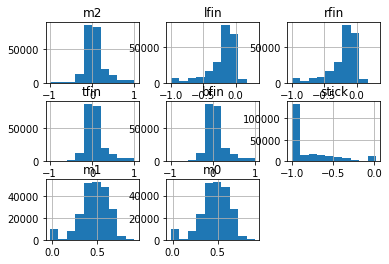

In [16]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_act.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8989ef1760>,
      dtype=object)

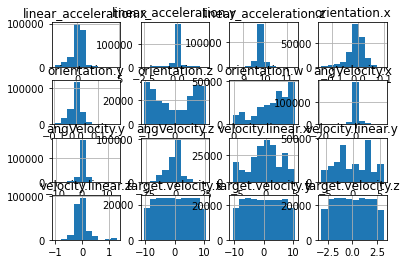

In [17]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.hist()

### Define Reward Function

In [18]:
class Define_rewardFn:
    def __init__(self):
        pass

    def reward_fn(
        self,
        next_obs_df,
        prev_act_list,
        prev_obs_list,
        obs_reward_weights=(1, 1),
        reward_weights=(1, 0, 1, 1),
        **params
    ):

        next_obsCost_np = 0
        next_obsCost_np = self.calculate_obsCost(
            next_obs_df, obs_reward_weights, **params
        )

        prev_obsCost_np = 0
        for obs_df in prev_obs_list:
            obsCost_np = self.calculate_obsCost(obs_df, obs_reward_weights, **params)
            prev_obsCost_np += obsCost_np

        prev_actCost_np = 0
        for act_df in prev_act_list:
            actCost_np = self.calculate_actCost(act_df, actCost_feature_list)
            prev_actCost_np += actCost_np

        prev_actChangeCost_np = 0
        for i in range(len(prev_act_list) - 1):
            act_df, next_act_df = prev_act_list[i], prev_act_list[i + 1]
            actChangeCost_np = self.calculate_actChangeCost(
                act_df, next_act_df, actChangeCost_feature_list
            )
            prev_actChangeCost_np += actChangeCost_np

        rewards = (
            reward_weights[0] * next_obsCost_np
            + reward_weights[1] * prev_obsCost_np
            + reward_weights[2] * prev_actCost_np
            + reward_weights[3] * prev_actChangeCost_np
        )

        rewards = pd.DataFrame({"rewards": rewards})
        info = pd.DataFrame(
            {
                "next_obsCost": next_obsCost_np,
                "prev_obsCost": prev_obsCost_np,
                "prev_actCost": prev_actCost_np,
                "prev_actChangeCost": prev_actChangeCost_np,
            }
        )
        return rewards, info

    def calculate_obsCost(self, obs_df, obs_reward_weights, **params):
        xy_target_df = obs_df[xy_target_feature_list]
        xy_cost_df = obs_df[xy_cost_feature_list]
        z_target_df = obs_df[z_target_feature_list]
        z_cost_df = obs_df[z_cost_feature_list]
        xyCost_np = obs_reward_weights[0] * self.calculate_xyCost(
            xy_cost_df, xy_target_df
        )
        zCost_np = obs_reward_weights[1] * self.calculate_zCost(z_cost_df, z_target_df)
        obs_cost_np = xyCost_np + zCost_np
        return obs_cost_np

    def calculate_xyCost(self, xy_df, xy_target_df):
        xyCost_np = xy_target_df.to_numpy() - xy_df.to_numpy()
        xyCost_np = -np.linalg.norm(xyCost_np, axis=1)
        return xyCost_np

    def calculate_zCost(self, z_df, z_target_df):
        zCost_np = z_target_df.to_numpy() - z_df.to_numpy()
        zCost_np = -np.abs(zCost_np).reshape(
            zCost_np.shape[0],
        )
        return zCost_np

    def calculate_actCost(self, act_df, actCost_feature_list):
        actCost_np = act_df[actCost_feature_list].to_numpy()
        actCost_np = -np.linalg.norm(actCost_np, axis=1)
        return actCost_np

    def calculate_actChangeCost(self, act_df, next_act_df, actChangeCost_feature_list):
        actChangeCost_np = (
            next_act_df[actChangeCost_feature_list].to_numpy()
            - act_df[actChangeCost_feature_list].to_numpy()
        )
        actChangeCost_np = -np.linalg.norm(actChangeCost_np, axis=1)
        return actChangeCost_np

    def split_xy(self, prev_act_list, prev_obs_list, next_obs, rewards):
        x_df_list = []
        for obs_df, act_df in zip(prev_obs_list, prev_act_list):
            obs_act_df = pd.concat([obs_df, act_df], axis=1)
            x_df_list.append(obs_act_df)
        x = pd.concat(x_df_list, axis=1)
        y = pd.concat([rewards, next_obs], axis=1)
        return x, y

    def main(self, objTrans, **params):
        prev_act_list, prev_obs_list = objTrans.get_prev_transitions_list()
        next_act, next_obs = objTrans.get_next_transitions()

        rewards, info = self.reward_fn(next_obs, prev_act_list, prev_obs_list, **params)
        x, y = self.split_xy(prev_act_list, prev_obs_list, next_obs, rewards)

        return x, y, rewards, info

In [19]:
clsDefineRewardFn = Define_rewardFn()
x_train, y_train, rewards_train, info_train = clsDefineRewardFn.main(
    objTrans_train, **params
)
x_test, y_test, rewards_test, info_test = clsDefineRewardFn.main(
    objTrans_test, **params
)

In [20]:
x_train

,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,...,target.velocity.y,target.velocity.z,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.584692,-0.003121,9.895689,-0.000153,0.023304,0.001966,0.999726,-0.023512,1.377563,0.031976,...,-3.049260,-1.730630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.594369,-0.002353,9.892905,-0.000150,0.023693,0.001969,0.999717,-0.013437,1.268200,0.032226,...,2.983398,-0.183213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.614525,0.000782,9.879537,-0.000144,0.024206,0.001974,0.999705,-0.012377,1.201045,0.032725,...,-0.828568,-0.052206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.625241,-0.001828,9.871389,-0.000136,0.025340,0.001989,0.999677,-0.018434,0.884534,0.036027,...,3.802951,-1.830933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.617526,-0.000545,9.875700,-0.000131,0.025696,0.001995,0.999668,-0.014570,0.687310,0.034509,...,-9.278278,2.089663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225535,0.486799,-0.075590,9.747105,0.005228,0.022223,-0.309563,0.967896,-0.250645,-0.187863,-0.289510,...,-0.465954,-2.628030,0.038747,0.084643,0.074453,-0.010617,-0.027363,-0.733162,0.237372,0.234468
225536,0.462993,-0.031990,9.778831,0.005328,0.016884,-0.300385,0.937151,-0.775285,-0.482646,0.900205,...,3.764059,1.745055,-0.009673,0.109011,0.108639,0.009932,-0.034453,-0.743895,0.225583,0.246602
225537,0.399804,-0.071891,9.756434,0.004253,0.024538,-0.323002,0.975974,0.535977,-0.345041,-0.655376,...,7.006832,0.183472,0.049702,0.095724,0.077941,-0.024519,-0.014413,-0.718953,0.227628,0.244060
225538,0.439147,-0.020686,9.762058,0.005371,0.020885,-0.263914,0.965769,-0.838774,-0.426436,-0.494270,...,-6.922346,2.642054,-0.005429,0.095937,0.068683,0.036197,0.017730,-0.714663,0.241016,0.240996


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2eb13a4850>,
      dtype=object)

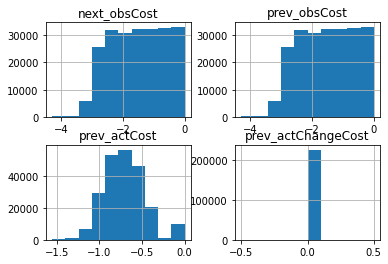

In [21]:
info_train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2eb1297cd0>]],
      dtype=object)

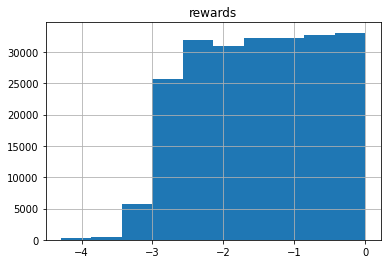

In [22]:
rewards_train.hist()

### Save data to csv

In [21]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.to_csv(os.path.join(SimResults_path,'obs'), index=False)
cur_act.to_csv(os.path.join(SimResults_path,'act'), index=False)
x_train.to_csv(os.path.join(SimResults_path,'x_train'), index=False)
y_train.to_csv(os.path.join(SimResults_path,'y_train'), index=False)
x_testc.to_csv(os.path.join(SimResults_path,'x_test'), index=False)
y_test.to_csv(os.path.join(SimResults_path,'y_test'), index=False)

In [22]:
act_read_test = pd.read_csv(os.path.join(SimResults_path,'act'))
obs_read_test = pd.read_csv(os.path.join(SimResults_path,'obs'))
x_train_read_test = pd.read_csv(os.path.join(SimResults_path,'x_train'))
y_train_read_test = pd.read_csv(os.path.join(SimResults_path,'y_train'))

In [29]:
x_train.columns

Index(['linear_acceleration.x', 'linear_acceleration.y',
       'linear_acceleration.z', 'orientation.x', 'orientation.y',
       'orientation.z', 'orientation.w', 'angVelocity.x', 'angVelocity.y',
       'angVelocity.z', 'velocity.linear.x', 'velocity.linear.y',
       'velocity.linear.z', 'target.velocity.x', 'target.velocity.y',
       'target.velocity.z', 'm2', 'lfin', 'rfin', 'tfin', 'bfin', 'stick',
       'm1', 'm0'],
      dtype='object')

In [23]:
act_real = pd.read_csv(os.path.join(RealResults_path,'act'))
obs_real = pd.read_csv(os.path.join(RealResults_path,'obs'))
x_train_real = pd.read_csv(os.path.join(RealResults_path,'x_train'))
y_train_real = pd.read_csv(os.path.join(RealResults_path,'y_train'))
x_test_real = pd.read_csv(os.path.join(RealResults_path,'x_test'))
y_test_real = pd.read_csv(os.path.join(RealResults_path,'y_test'))

In [24]:
act_mix = pd.concat([cur_act, act_real], axis = 0)
obs_mix = pd.concat([cur_obs, obs_real], axis = 0)
x_train_mix = pd.concat([x_train, x_train_real], axis = 0)
y_train_mix = pd.concat([y_train, y_train_real], axis = 0)
x_test_mix = pd.concat([x_test, x_test_real], axis = 0)
y_test_mix = pd.concat([y_test, y_test_real], axis = 0)

In [25]:
obs_mix.to_csv(os.path.join(mix_results_path,'obs'), index=False)
act_mix.to_csv(os.path.join(mix_results_path,'act'), index=False)
x_train_mix.to_csv(os.path.join(mix_results_path,'x_train'), index=False)
y_train_mix.to_csv(os.path.join(mix_results_path,'y_train'), index=False)
x_test_mix.to_csv(os.path.join(mix_results_path,'x_test'), index=False)
y_test_mix.to_csv(os.path.join(mix_results_path,'y_test'), index=False)

<AxesSubplot:>

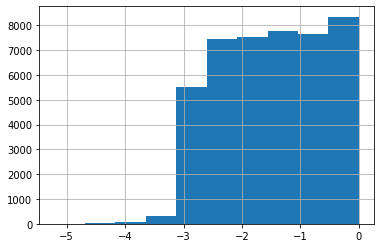

In [26]:
y_test_mix['rewards'].hist()

In [27]:
x_train_mix

,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,...,target.velocity.y,target.velocity.z,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.584692,-0.003121,9.895689,-0.000153,0.023304,0.001966,0.999726,-0.023512,1.377563,0.031976,...,-0.943869,-1.234034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.594369,-0.002353,9.892905,-0.000150,0.023693,0.001969,0.999717,-0.013437,1.268200,0.032226,...,0.353846,1.579909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.614525,0.000782,9.879537,-0.000144,0.024206,0.001974,0.999705,-0.012377,1.201045,0.032725,...,2.199913,2.311245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.625241,-0.001828,9.871389,-0.000136,0.025340,0.001989,0.999677,-0.018434,0.884534,0.036027,...,-2.703278,1.473661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.617526,-0.000545,9.875700,-0.000131,0.025696,0.001995,0.999668,-0.014570,0.687310,0.034509,...,2.373156,2.596013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80361,1.941346,-0.947145,-9.831277,-0.069617,0.109328,0.794002,0.598270,0.377081,-2.695616,6.921923,...,-0.000353,0.005413,0.014320,-0.459337,-0.454241,0.016076,0.024715,-0.822623,0.290958,0.271392
80362,-1.305720,-0.020948,-10.089717,0.032682,0.008950,0.862210,0.393324,-1.701011,2.873294,13.420953,...,-0.319656,0.261434,-0.792495,-0.076638,-0.046882,-0.835725,-0.806181,-0.228864,-0.002130,0.040600
80363,0.793770,-0.757124,-9.585815,-0.009528,-0.005290,0.985803,-0.292112,-2.086832,-3.446179,10.151603,...,-0.157587,0.118352,0.477381,-0.167209,-0.225745,0.493111,0.482280,-0.637657,0.377142,0.364195
80364,-0.002370,0.117794,-8.993156,0.008098,-0.015454,0.898349,-0.488930,-10.103483,-20.460791,-48.344696,...,-0.158517,0.283394,0.627096,0.002583,0.023373,0.562000,0.597742,-0.652511,0.040889,0.061862
